# Introduction

QA plots for the TPC detector

In [1]:
# imports to write dynamic markdown contents
import os
from IPython.display import display, Markdown, Latex
from IPython.display import HTML

In [2]:
# turn off/on code for the result HTML page

display(Markdown('*For the result HTML page:* '))
    
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

*For the result HTML page:* 

## `pyROOT` env check

In [3]:
import ROOT

OFFLINE_MAIN = os.getenv("OFFLINE_MAIN")
if OFFLINE_MAIN is not None:
    display(Markdown(f"via sPHENIX software distribution at `{OFFLINE_MAIN}`"))

Welcome to JupyROOT 6.22/02


via sPHENIX software distribution at `/cvmfs/sphenix.sdcc.bnl.gov/gcc-8.3/release/release_new/new.4`


# Initialization

In [4]:
%%cpp -d


#include <sPhenixStyle.C>

#include <TFile.h>
#include <TLine.h>
#include <TString.h>
#include <TTree.h>
#include <cassert>
#include <cmath>

In [5]:
%%cpp

// SetsPhenixStyle();

gStyle->SetOptStat(0);
TVirtualFitter::SetDefaultFitter("Minuit2");
gSystem->Load("libqa_modules")

(int) 0


## Inputs and file checks

In [6]:
%%cpp

TFile *qa_file_new = new TFile("data/G4EICDetector_DSTReader_FEMC-scan.10k.root");
    
if (qa_file_new == nullptr) 
{
    cout <<"Error, can not open QA root file"<<qa_file_name_new<<endl;
}

TTree * T = nullptr; 

qa_file_new->GetObject("T", T);

    
if (T == nullptr) 
{
    cout <<"Error, can not open T Tree"<<endl;
}

In [7]:
%%cpp
T->Show(0);

======> EVENT:0
 n_G4HIT_BH_1    = 0
 n_G4HIT_BH_FORWARD_PLUS = 0
 n_G4HIT_BH_FORWARD_NEG = 0
 n_TOWER_SIM_FEMC = 0
 n_TOWER_RAW_FEMC = 0
 n_TOWER_CALIB_FEMC = 0
 n_PHG4Particle  = 1
 PHG4Particle    = 1
 PHG4Particle.fUniqueID = 0
 PHG4Particle.fBits = 50331648
 PHG4Particle.fname = e-
 PHG4Particle.fpid = 11
 PHG4Particle.fpx = -0.443205
 PHG4Particle.fpy = -0.0169334
 PHG4Particle.fpz = 9.99016
 PHG4Particle.barcode = -1
 PHG4Particle.trkid = 1
 PHG4Particle.vtxid = 1
 PHG4Particle.parentid = 0
 PHG4Particle.primaryid = 1
 PHG4Particle.fe = 10
 n_PHG4VtxPoint  = 1
 PHG4VtxPoint    = 1
 PHG4VtxPoint.fUniqueID = 0
 PHG4VtxPoint.fBits = 50331648
 PHG4VtxPoint.vx = 0
 PHG4VtxPoint.vy = 0
 PHG4VtxPoint.vz = 2.57181
 PHG4VtxPoint.t0 = 0
 PHG4VtxPoint.id = 1


## 2D calorimeter energy containment 

* Top left: Sum of energy response of all sim towers (visible components only)
* Top right: sum of electron energy at vertex 
* Bottom: ratio of the above two, which for each bin gives the ratio of energy containment * visible sampling fraction in FEMC

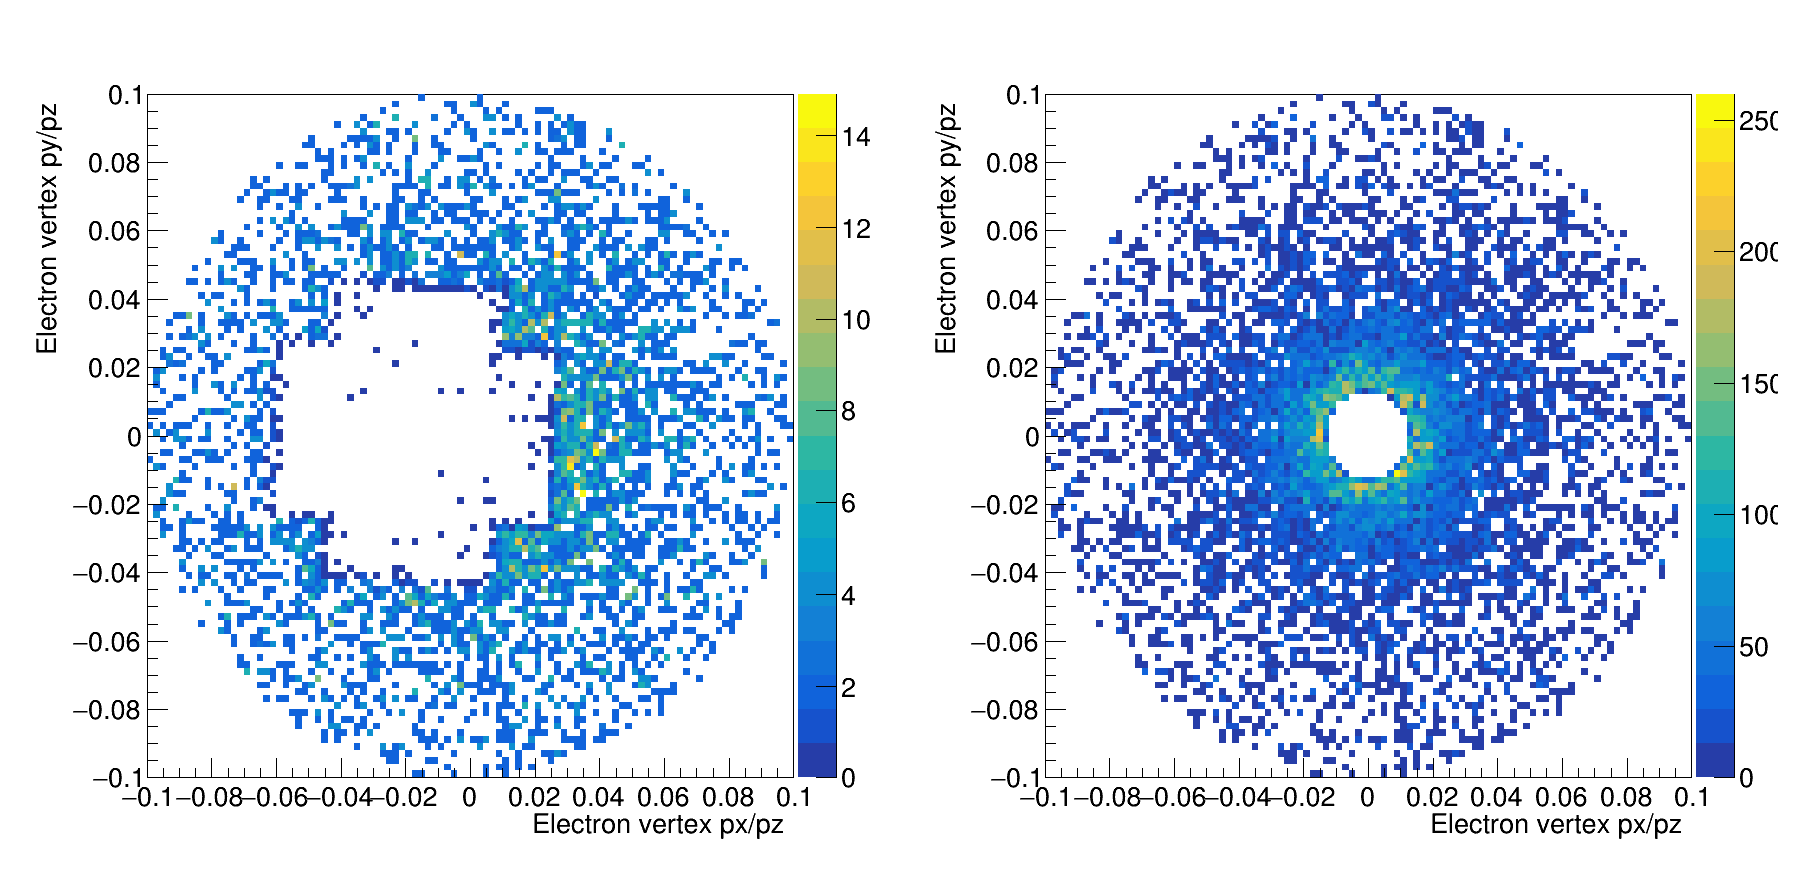

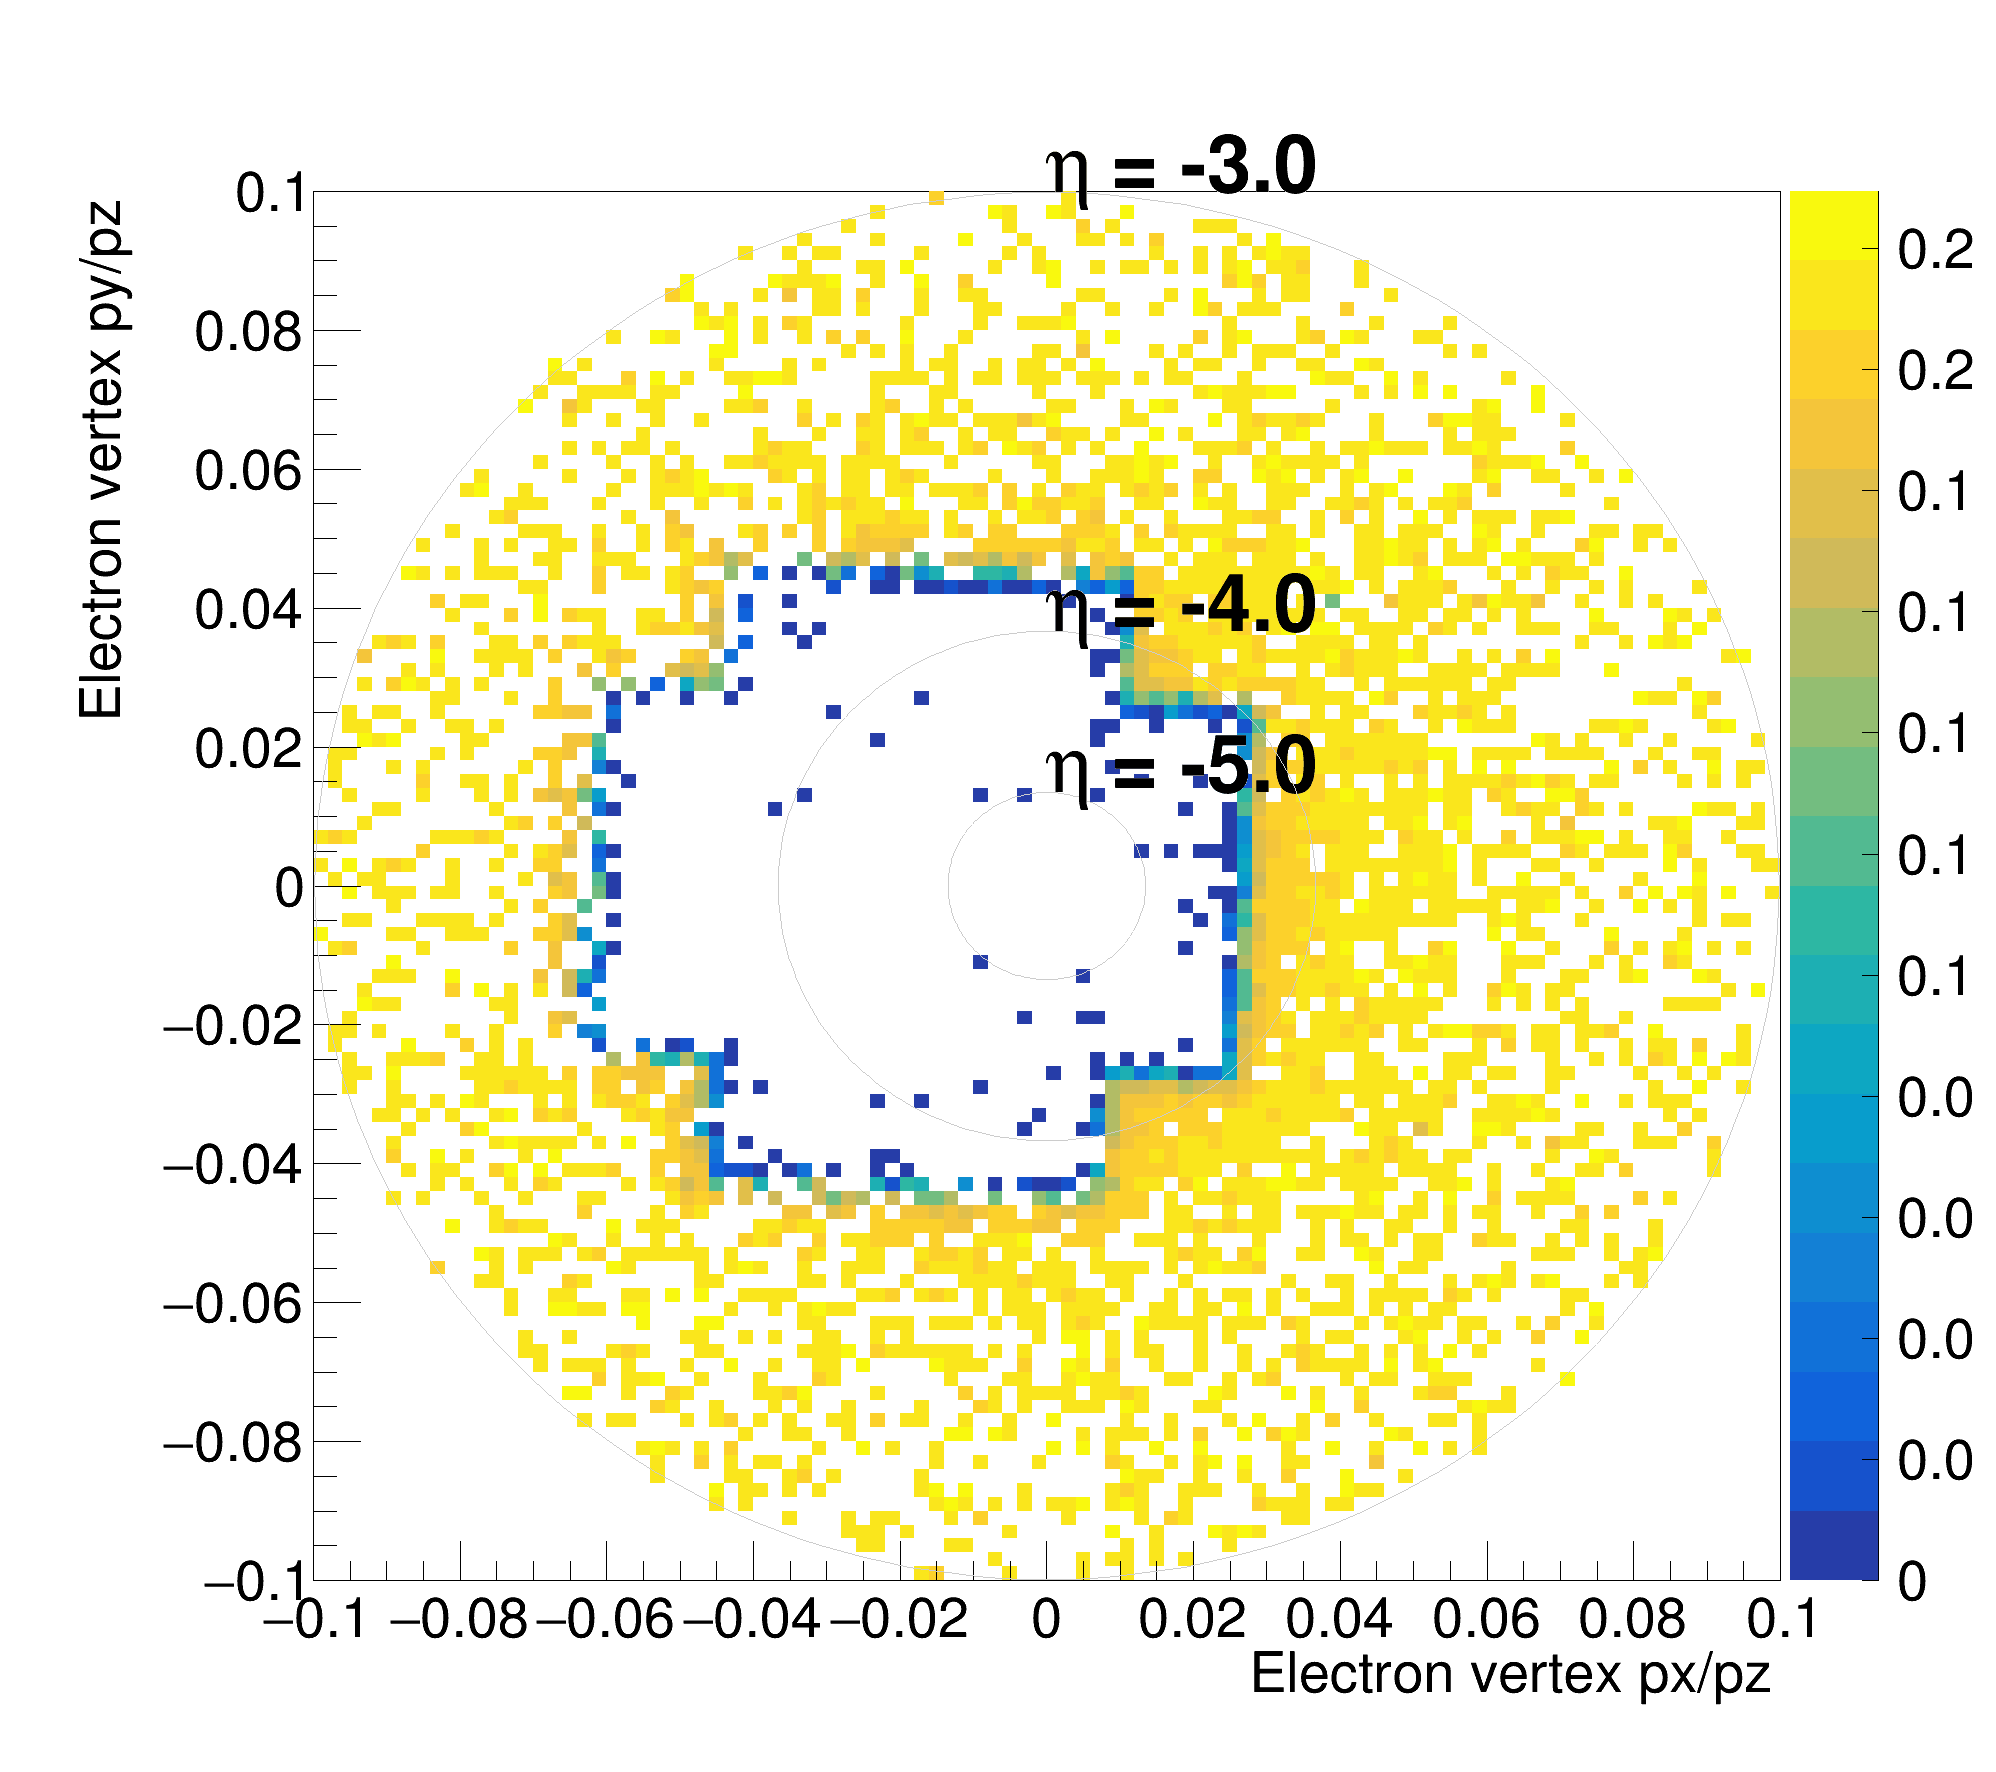

In [8]:
%%cpp

{
    const int n_Seg = 100;
    
    const char *hist_name_prefix = "TowerScan";
    auto c1 = new TCanvas(TString("TowerScan") ,
                        TString("TowerScan"),
                        1800, 900);

    c1->Divide(2, 1);
    int idx = 1;
    TPad *p;

        TH2F * hSumE2D = new TH2F("hSumE2D",";Electron vertex px/pz;Electron vertex py/pz",n_Seg,-.1,.1,n_Seg,-.1,.1);
    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        // p->SetLogy();
        
    gPad->SetLeftMargin(0.15);
        T->Draw("PHG4Particle[0].fpy/PHG4Particle[0].fpz:PHG4Particle[0].fpx/PHG4Particle[0].fpz>>hSumE2D","Sum$(TOWER_SIM_FEMC.get_energy())","colz")     ;   
    }

        TH2F * hSumTruthE2D = new TH2F("hSumTruthE2D",";Electron vertex px/pz;Electron vertex py/pz",n_Seg,-.1,.1,n_Seg,-.1,.1);
    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        
    gPad->SetLeftMargin(0.15);
        
        T->Draw("PHG4Particle[0].fpy/PHG4Particle[0].fpz:PHG4Particle[0].fpx/PHG4Particle[0].fpz>>hSumTruthE2D","PHG4Particle[0].fe","colz")     ;
        
    }
    
    c1->Draw();
    
    {
    c1 = new TCanvas(TString("Tower2DRatio") ,
                        TString("Tower2DRatio"),
                        2000, 1800);

    c1->Divide(1, 1);
    int idx = 1;
    TPad *p;
    
        p = (TPad *) c1->cd(idx++);
        c1->Update();
    
    p->SetLeftMargin(0.15);
    //    p->DrawFrame(-.1,-.1,.1,.1);
    
    TH2F * hSumRatio2D = (TH2F *)hSumE2D->Clone("hSumRatio2D");
    
    hSumRatio2D->Divide(hSumE2D, hSumTruthE2D, 1, 1, "B");
    
    hSumRatio2D->Draw("COLZ");

    //hSumRatio2D->SetMaximum(1);

    hSumRatio2D->GetZaxis()->SetTickSize(0.01);
    hSumRatio2D->GetZaxis()->SetLabelOffset(0.01);
    hSumRatio2D->GetZaxis()->SetTitleOffset(1.3);

    
    vector<double> etas {-5, -4, -3};
    for (double eta : etas)
    {
        const double theta = -2 * atan(exp(-eta));        
        
        int n = 200;
        vector<double> xs(n+1);
        vector<double> ys(n+1);
        
        for (int i=0; i<=n; ++i)
        {
            xs[i] = tan(theta) * cos(((double)i)/n*2*TMath::Pi());
            ys[i] = tan(theta) * sin(((double)i)/n*2*TMath::Pi());
        }
        
        TPolyLine *pline = new TPolyLine(n+1,xs.data(),ys.data());
       pline->SetLineColor(kGray);
       pline->SetFillStyle(0);
       pline->Draw();
        
        TLatex * t = new TLatex(0, tan(theta), Form("#eta = %.1f", eta));
        t->Draw();
    
    }
        
    
    c1->Draw();
    }
}

## 1D eta-dependent calorimeter energy containment 

* Top left: Sum of energy response of all towers
* Top right: sum of electron energy at vertex 
* Bottom: ratio of the above two, which for each bin gives the ratio of energy containment in FEMC

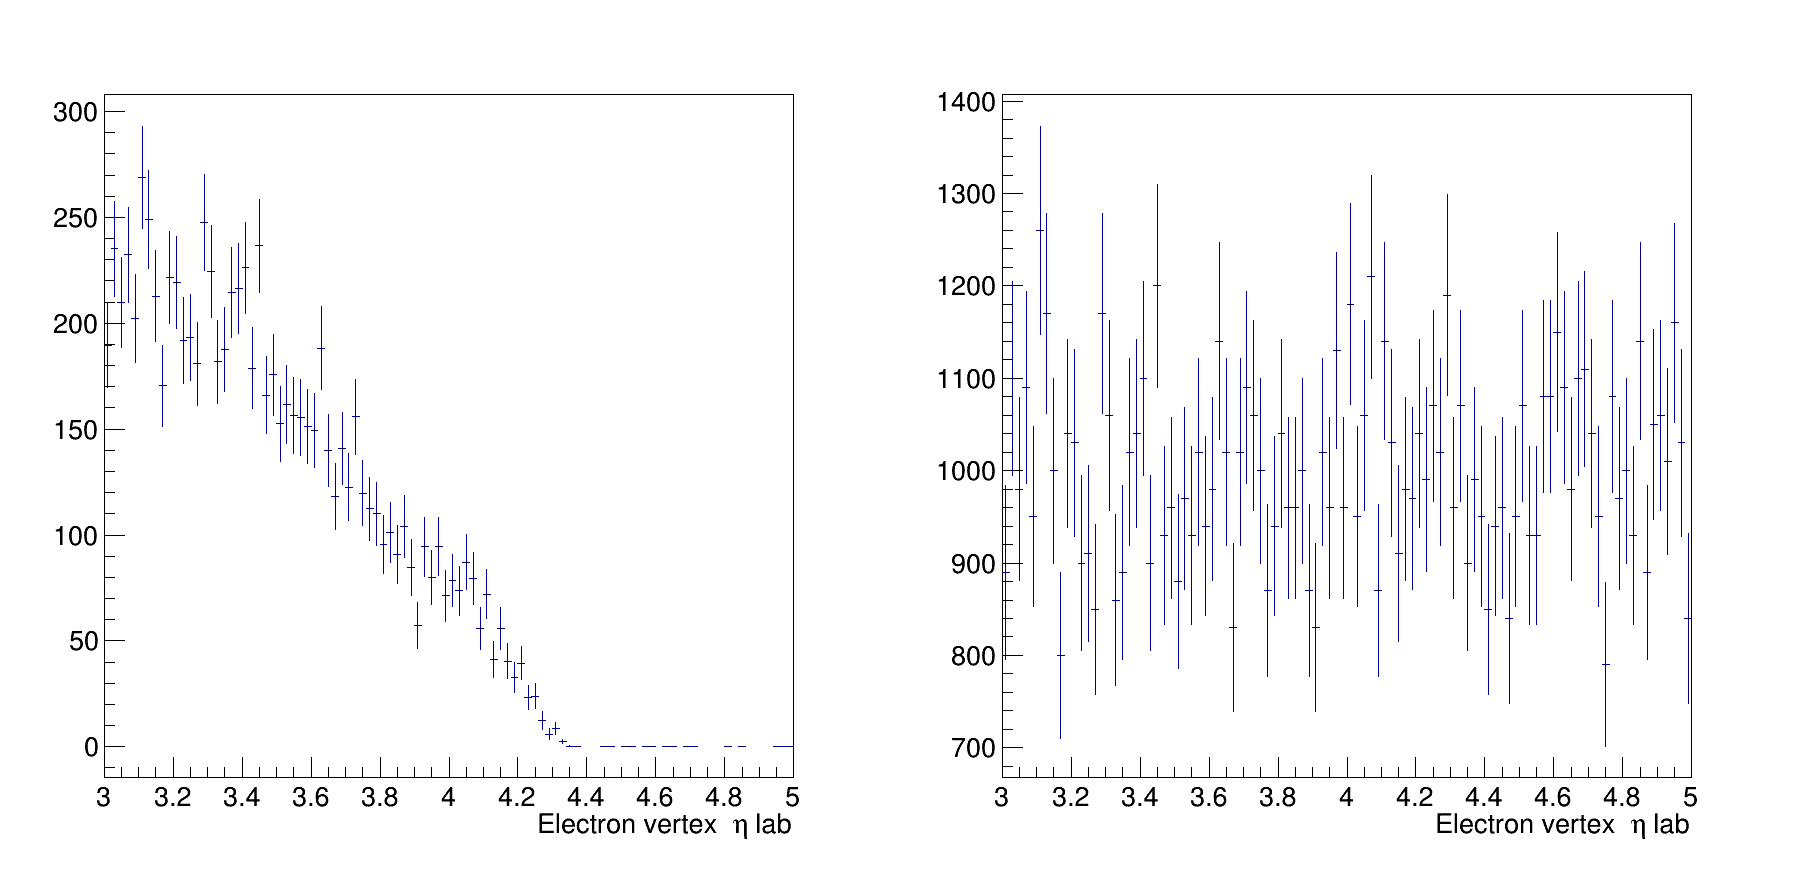

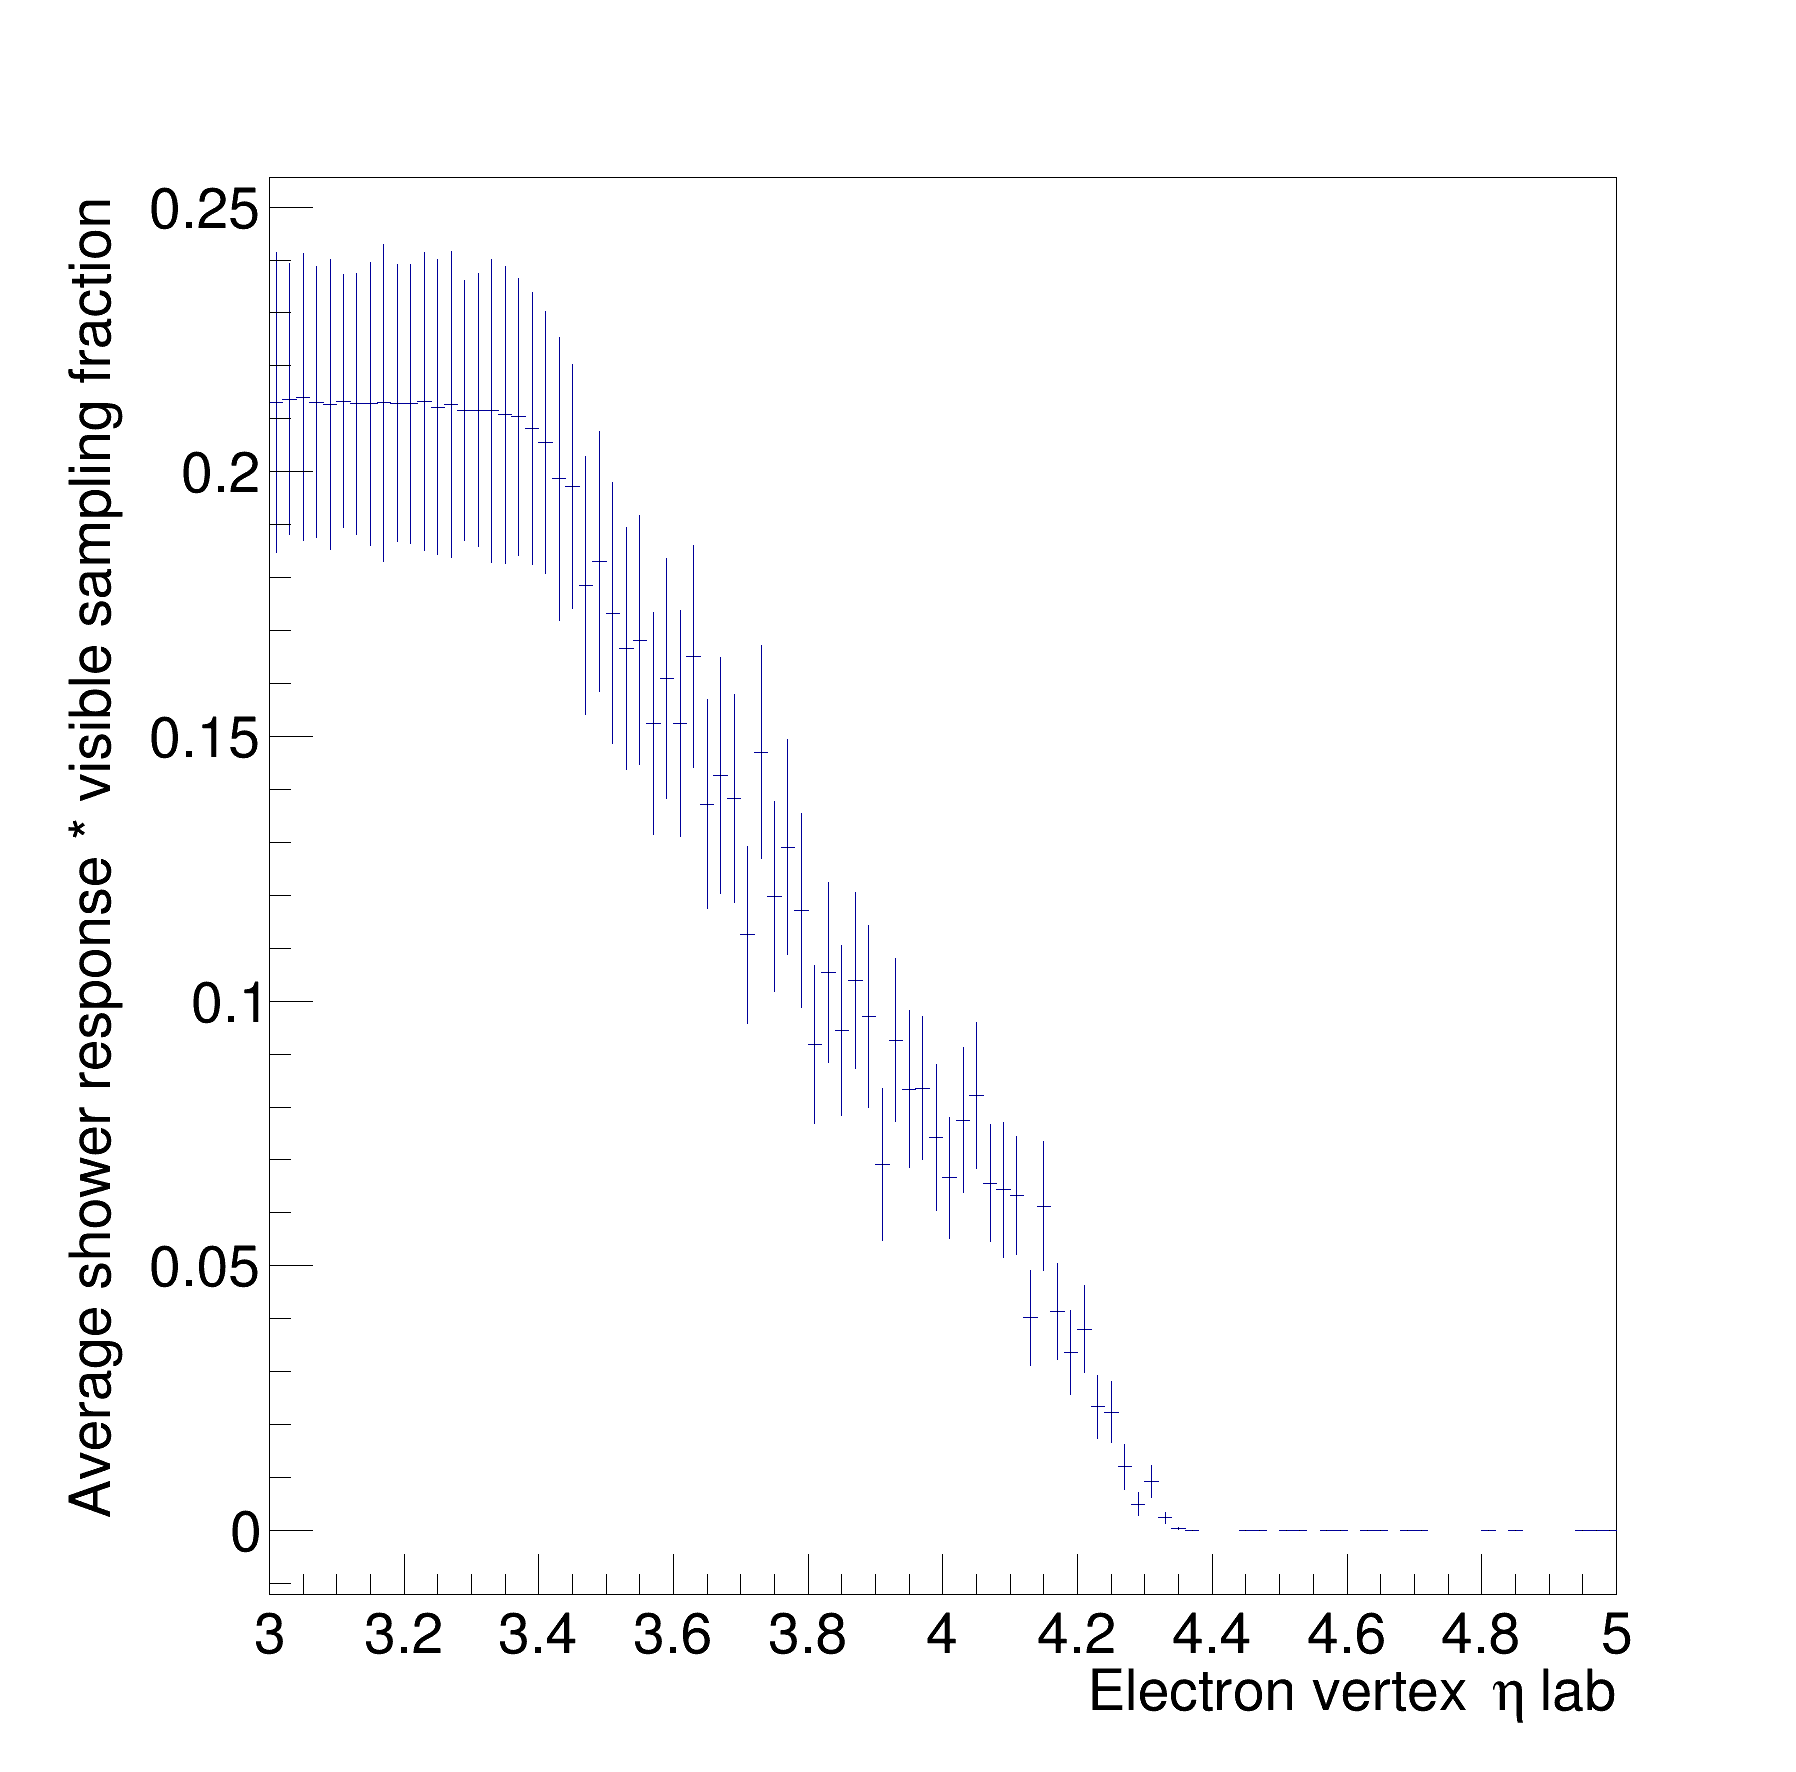

In [9]:
%%cpp

{
    const int n_Seg = 100;
    
    const char *hist_name_prefix = "Tower1D";
    auto c1 = new TCanvas(TString("Tower1D") ,
                        TString("Tower1D"),
                        1800, 900);

    c1->Divide(2, 1);
    int idx = 1;
    TPad *p;

        TH1F * hSumEEta = new TH1F("hSumEEta",";Electron vertex #eta lab",n_Seg,3,5);
    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        // p->SetLogy();
        
        T->Draw("TMath::ATanH(PHG4Particle[0].fpz/sqrt((PHG4Particle[0].fpx)**2 + PHG4Particle[0].fpy**2 + PHG4Particle[0].fpz**2))>>hSumEEta","Sum$(TOWER_SIM_FEMC.get_energy())")     ;   
    }

        TH1F * hSumVertexEEta = new TH1F("hSumVertexEEta",";Electron vertex #eta lab",n_Seg,3,5);
    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        
        T->Draw("TMath::ATanH(PHG4Particle[0].fpz/sqrt((PHG4Particle[0].fpx)**2 + PHG4Particle[0].fpy**2 + PHG4Particle[0].fpz**2))>>hSumVertexEEta","PHG4Particle[0].fe","colz")     ;
        
    }
    
    c1->Draw();
    
    
    c1 = new TCanvas(TString("Tower1DRatio") ,
                        TString("Tower1DRatio"),
                        1800, 1800);

    TH1 * hSumRatioEta = (TH1 *)hSumEEta->Clone("hSumRatioEta");
    
    hSumRatioEta->GetYaxis()->SetTitle("Average shower response * visible sampling fraction");
    
    hSumRatioEta->Divide(hSumRatioEta, hSumVertexEEta, 1, 1, "B");
    
    hSumRatioEta->Draw();

    gPad->SetLeftMargin(0.15);
    
    
    c1->Draw();
}

Warning in <TCanvas::Constructor>: Deleting canvas with same name: Tower1D
Warning in <TFile::Append>: Replacing existing TH1: hSumEEta (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hSumVertexEEta (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: Tower1DRatio


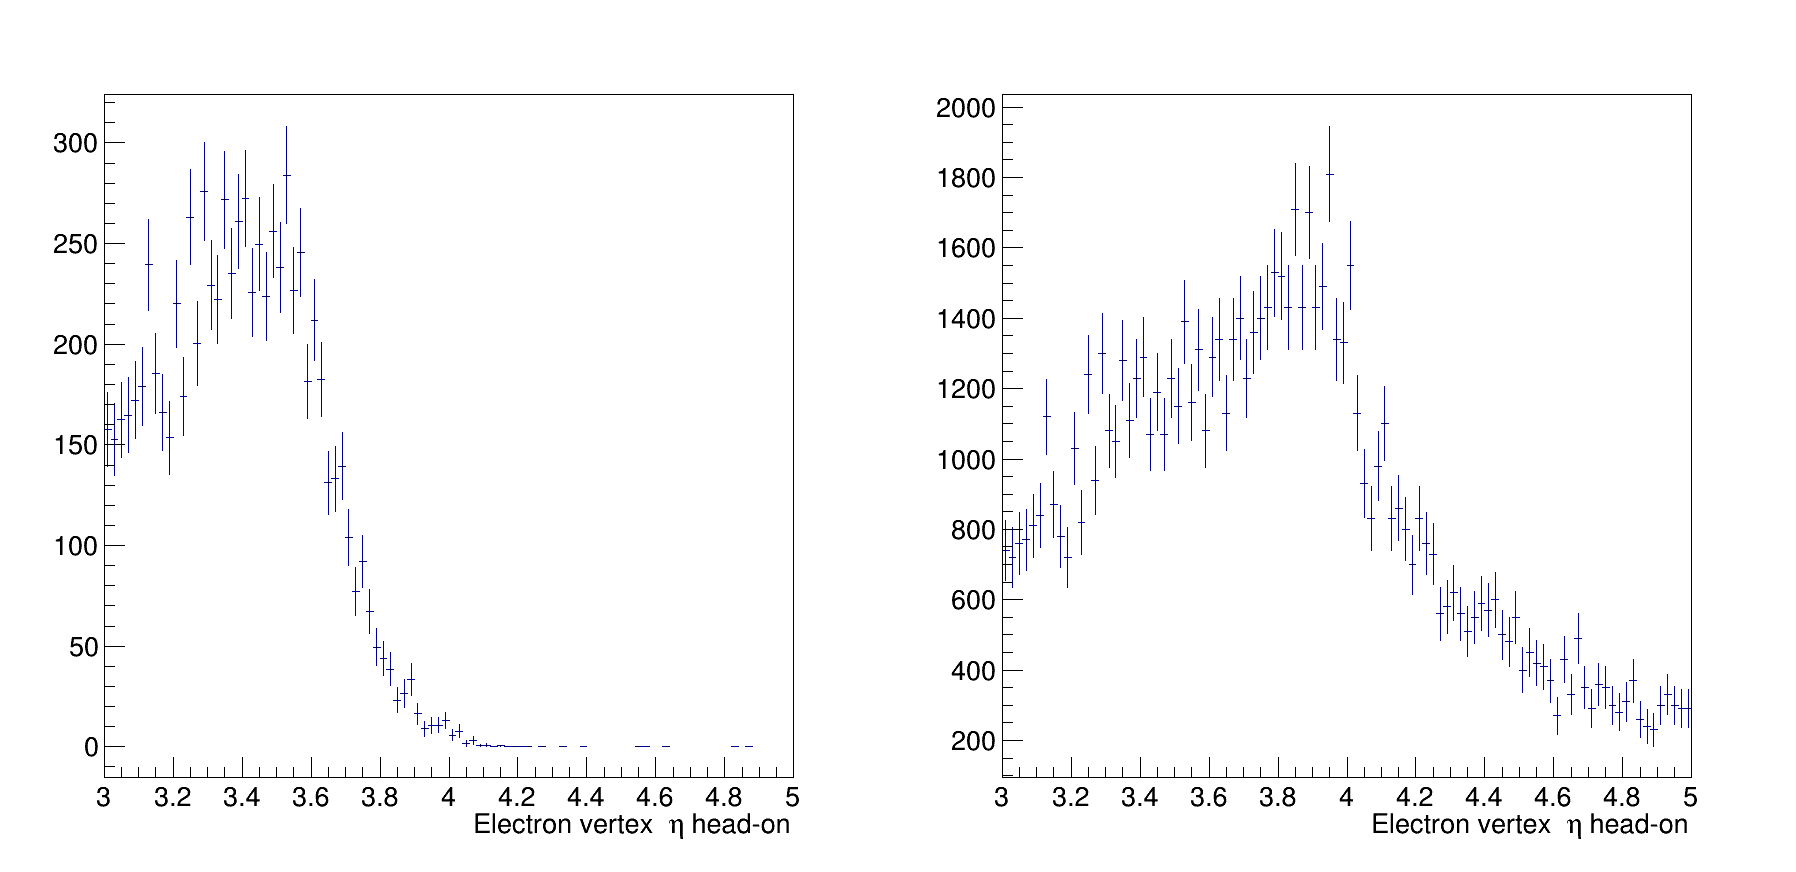

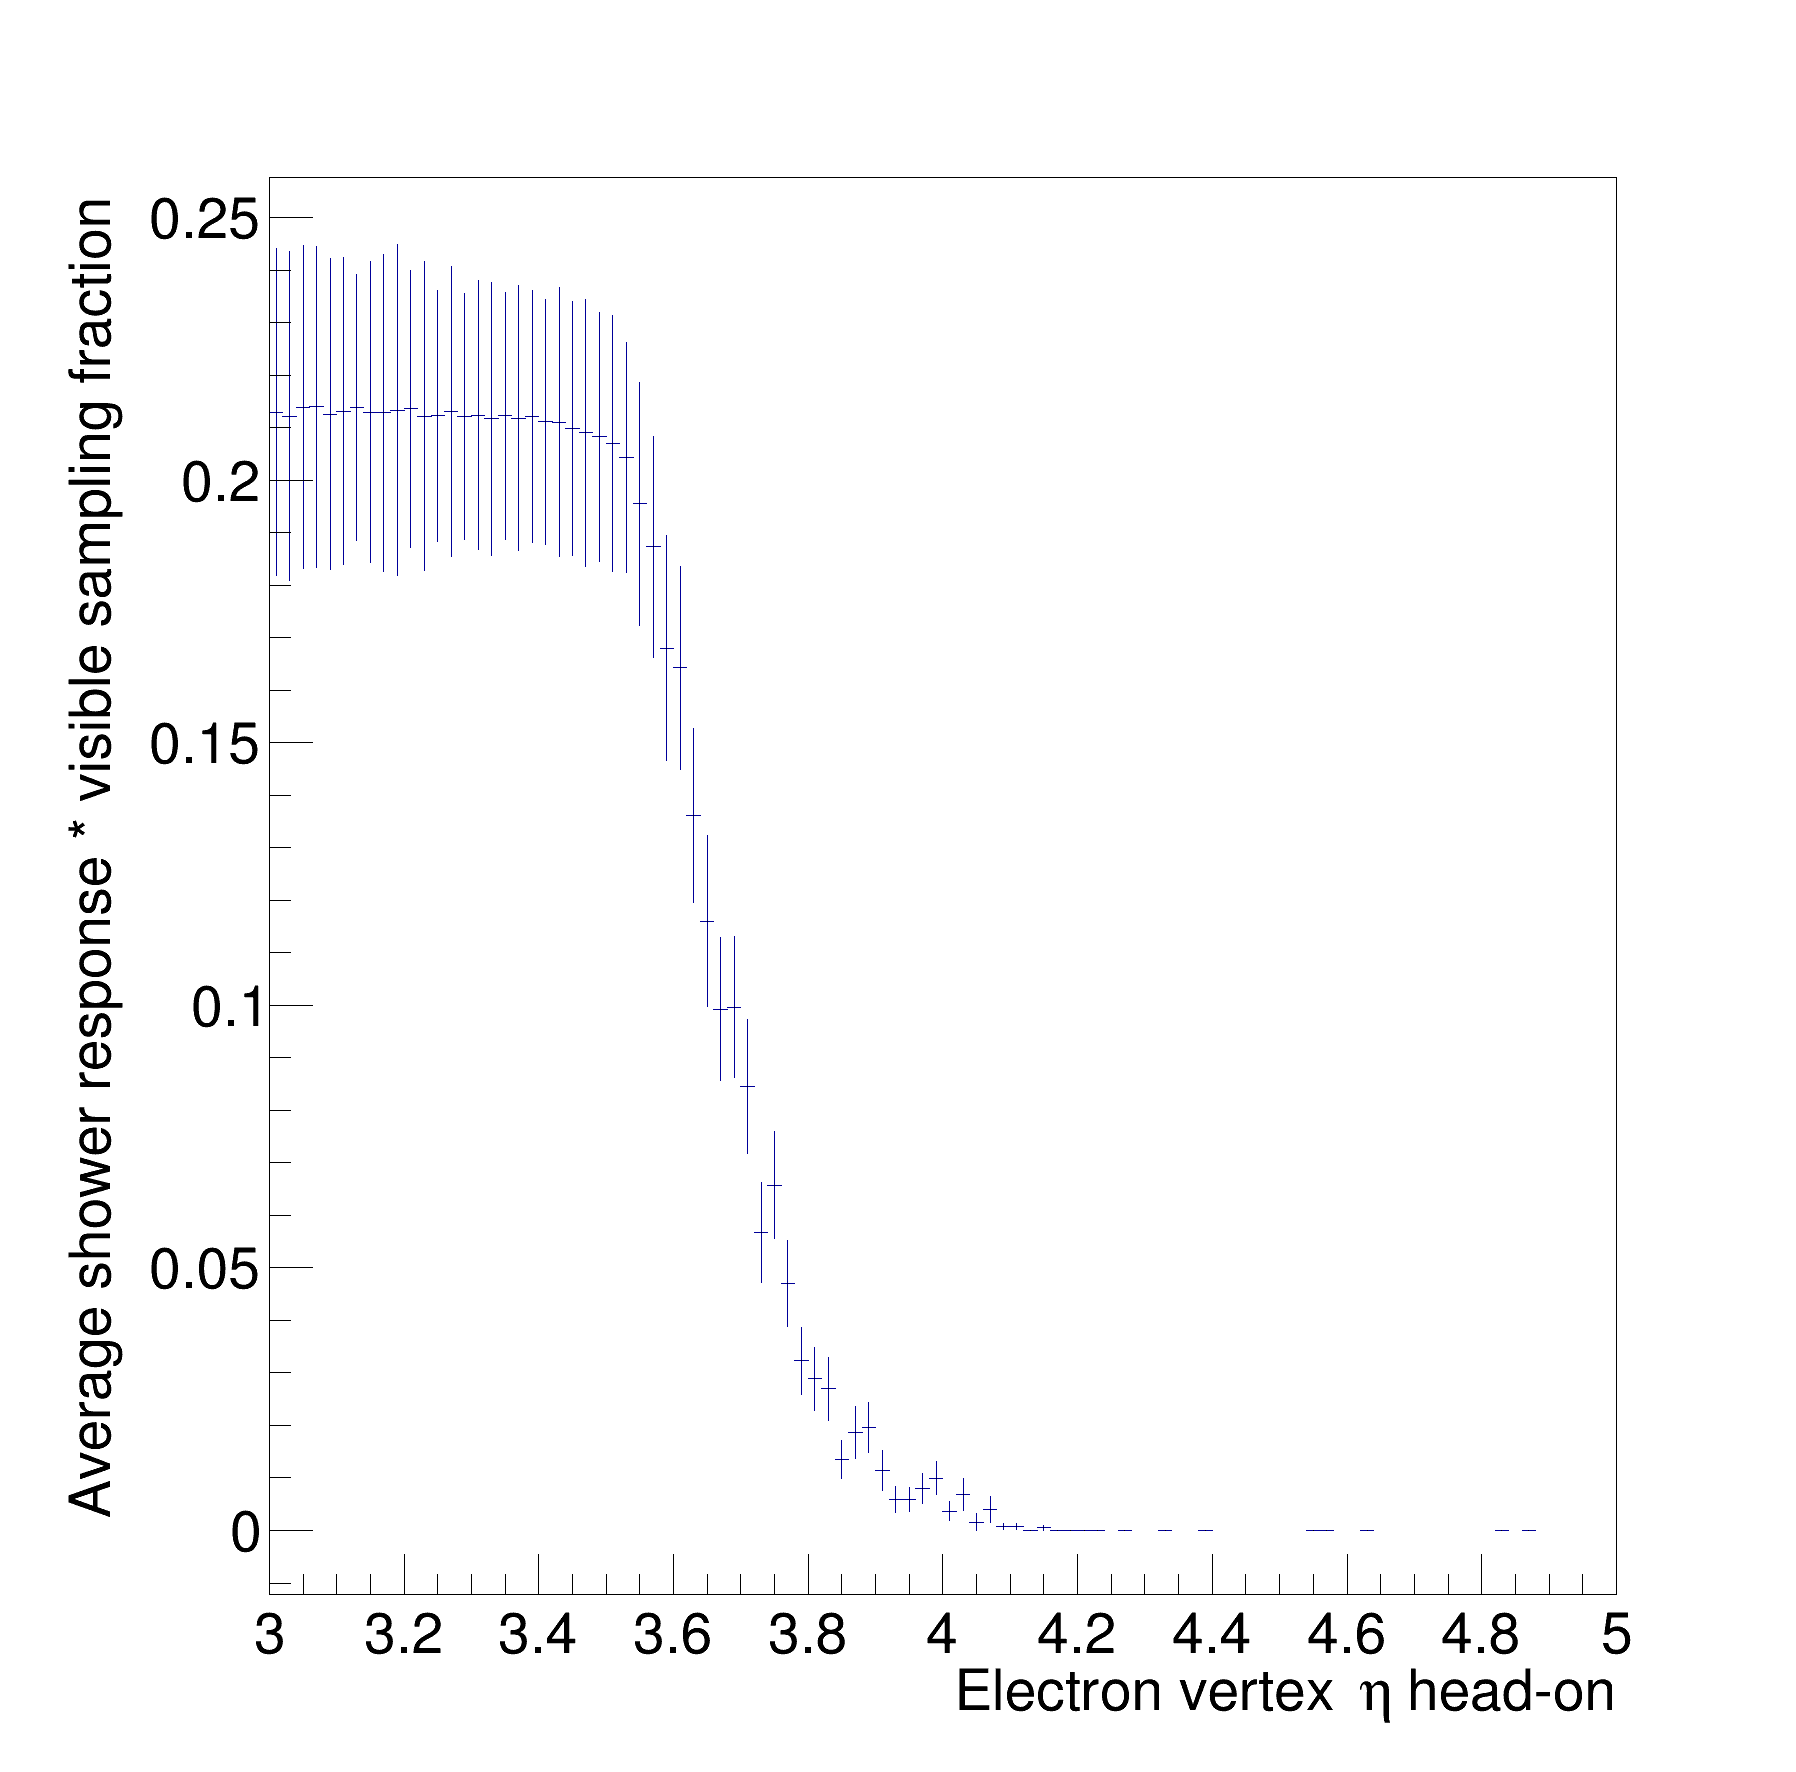

In [10]:
%%cpp

{
    const int n_Seg = 100;
    
    const char *hist_name_prefix = "Tower1D";
    auto c1 = new TCanvas(TString("Tower1D") ,
                        TString("Tower1D"),
                        1800, 900);

    c1->Divide(2, 1);
    int idx = 1;
    TPad *p;

        TH1F * hSumEEta = new TH1F("hSumEEta",";Electron vertex #eta head-on",n_Seg,3,5);
    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        // p->SetLogy();
        
        T->Draw("TMath::ATanH(PHG4Particle[0].fpz/sqrt((PHG4Particle[0].fpx + 25e-3*PHG4Particle[0].fpz)**2 + PHG4Particle[0].fpy**2 + PHG4Particle[0].fpz**2))>>hSumEEta","Sum$(TOWER_SIM_FEMC.get_energy())")     ;   
    }

        TH1F * hSumVertexEEta = new TH1F("hSumVertexEEta",";Electron vertex #eta head-on",n_Seg,3,5);
    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        
        T->Draw("TMath::ATanH(PHG4Particle[0].fpz/sqrt((PHG4Particle[0].fpx + 25e-3*PHG4Particle[0].fpz)**2 + PHG4Particle[0].fpy**2 + PHG4Particle[0].fpz**2))>>hSumVertexEEta","PHG4Particle[0].fe","colz")     ;
        
    }
    
    c1->Draw();
    
    
    c1 = new TCanvas(TString("Tower1DRatio") ,
                        TString("Tower1DRatio"),
                        1800, 1800);

    TH1 * hSumRatioEta = (TH1 *)hSumEEta->Clone("hSumRatioEta");
    
    hSumRatioEta->GetYaxis()->SetTitle("Average shower response * visible sampling fraction");
    
    hSumRatioEta->Divide(hSumRatioEta, hSumVertexEEta, 1, 1, "B");
    
    hSumRatioEta->Draw();

    gPad->SetLeftMargin(0.15);
    
    
    c1->Draw();
}